In [1]:
from time import time
from __future__ import division, print_function
import os
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, model_from_json, Sequential
from keras.layers import Input, Embedding, LSTM, Lambda, Softmax, Dense, Concatenate, Dropout, Add, add, concatenate, Reshape, Flatten, dot, Bidirectional, Conv1D, GlobalMaxPooling1D, MaxPool2D, Conv2D
import keras.backend as K
from keras.optimizers import Adadelta, Adam
from keras.callbacks import ModelCheckpoint

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
TRAIN_CSV = '/content/drive/My Drive/Sem 3-2/NLA/Project/train.csv'
TEST_CSV = '/content/drive/My Drive/Sem 3-2/NLA/Project/test.csv'
MODEL_SAVING_DIR = '/content/drive/My Drive/Sem 3-2/NLA/Project/Models/'

# Make changes here for embedding and model name
# for malstm change the loss function also
MODEL_NAME = 'lstm_w2v_softmax'
EMBEDDING_TYPE = 'w2v' # w2v, glove

if EMBEDDING_TYPE == 'w2v':
  EMBEDDING_FILE = '/content/drive/My Drive/Sem 3-2/NLA/Project/GoogleNews-vectors-negative300.bin.gz'
elif EMBEDDING_TYPE == 'glove':
  EMBEDDING_FILE = '/content/drive/My Drive/Sem 3-2/NLA/Project/glove/glove.6B.100d.txt'

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
# Load training and test set
train_df = pd.read_csv(TRAIN_CSV)

stops = set(stopwords.words('english'))

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

# Prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding

if EMBEDDING_TYPE == 'w2v':
  word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

elif EMBEDDING_TYPE == 'glove':
  embeddings_index = dict()
  glove_vocab = []
  f = open(EMBEDDING_FILE)  # glove.6B.100d.txt
  for line in f:
    values = line.split()
    word = values[0]
    glove_vocab.append(word)
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
  f.close()

questions_cols = ['question1', 'question2']

# Iterate over the questions only of both training and test datasets
for index, row in train_df.iterrows():

    for question in questions_cols:

        q2n = []  # q2n -> question numbers representation
        for word in text_to_word_list(row[question]):

            # Stop word removal
            if EMBEDDING_TYPE == 'w2v':
              if word in stops and word not in word2vec.vocab:
                  continue
                  
            elif EMBEDDING_TYPE == 'glove':
              if word in stops and word not in glove_vocab:
                continue

            if word not in vocabulary:
                vocabulary[word] = len(inverse_vocabulary)
                q2n.append(len(inverse_vocabulary))
                inverse_vocabulary.append(word)
            else:
                q2n.append(vocabulary[word])

        # Replace questions as word to question as number representation
        train_df.at[index, question] = q2n

if EMBEDDING_TYPE == 'w2v':            
  embedding_dim = 300
  embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
  embeddings[0] = 0  # So that the padding will be ignored

  # Build the embedding matrix
  for word, index in vocabulary.items():
      if word in word2vec.vocab:
          embeddings[index] = word2vec.word_vec(word)
  del word2vec

elif EMBEDDING_TYPE == 'glove':
  embedding_dim = 100
  vocabulary_size = len(vocabulary) + 1
  embeddings = np.zeros((vocabulary_size, 100))
  for word, index in vocabulary.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embeddings[index] = embedding_vector

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max())

# Split to train validation test
test_size = 40000
validation_size = 40000
training_size = len(train_df) - validation_size - test_size

X = train_df[questions_cols]
Y = train_df['is_duplicate']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=validation_size)

# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': X_test.question1, 'right': X_test.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values
Y_test = Y_test.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation, X_test], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [0]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec + rec + K.epsilon()))

In [12]:
# load json and create model
json_file = open(MODEL_SAVING_DIR + MODEL_NAME + ".json", 'rb')
loaded_model_json = json_file.read()
json_file.close()
lstm = model_from_json(loaded_model_json)

# load weights into new model
lstm.load_weights(MODEL_SAVING_DIR + MODEL_NAME +".h5")

optimizer = Adam(learning_rate=0.001)
lstm.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', recall, precision, f1])

loss, acc, rec, prec, f1 = lstm.evaluate([X_test['left'], X_test['right']], Y_test)
print("Loss =", loss, "Accuracy =", acc, "Recall =", rec, "Precision =", prec, "F1 =", f1)

40000/40000 [==============================] - 106s 3ms/step
Loss = 0.4173725254893303 Accuracy = 0.8076500296592712 Recall = 0.6371176242828369 Precision = 0.8009285926818848 F1 = 0.6996744275093079


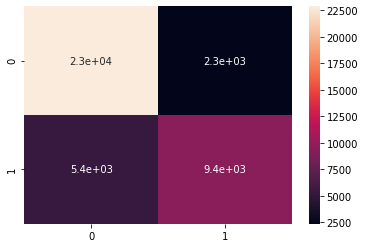

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

pred = lstm.predict([X_test['left'], X_test['right']])
cm = confusion_matrix(Y_test, pred.round())
sn.heatmap(cm, annot=True)